
# 생체인증보안 얼굴인식 과제 1
1971063 김윤서

## 0. 필요한 라이브러리 불러오기

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
from os.path import isfile, join
import glob
import gzip
from PIL import Image
from scipy import misc


In [89]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [90]:

# CNN
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.utils.np_utils import to_categorical

from keras import layers, regularizers, optimizers, callbacks
from collections import defaultdict
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float

from keras import layers
from keras import models
from keras.utils import np_utils  # to_categorical

In [91]:
# 탐지 결과(recall, precision, f1-score)에 사용할 함수들
from keras import backend as K

def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall

def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    return _f1score

In [92]:
# 학습 결과 분석을 위한 그래프 구현

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

# 1. 데이터 불러오기, 전처리

In [93]:
W = 144
H = 144
Nout = 351  #350명의 얼굴 데이터

epochs=100
batch_size=100

faces = []
labels = []


train_dir = '/content/drive/MyDrive/face-training-set'
filenames = os.listdir(train_dir)


In [94]:
from sklearn.model_selection import train_test_split

for filename in filenames[:-1]:
    label = filename.split("_")
    label = int(label[0])
    
    image = cv2.imread(train_dir+'/'+filename)
    image = np.array(image).reshape((-1))
    image = cv2.resize(np.float32(image), (W,H))
    faces.append(image)
    
    #label = label.lstrip("0")
    #label = str(label)
    #label=int(label)
    labels.append(label)


print(labels)

[11, 11, 14, 18, 10, 23, 22, 25, 22, 22, 20, 25, 20, 26, 25, 26, 19, 19, 23, 20, 21, 24, 27, 26, 24, 24, 27, 23, 27, 28, 21, 28, 21, 31, 31, 30, 31, 32, 36, 30, 28, 37, 35, 30, 29, 29, 36, 32, 37, 35, 33, 29, 33, 35, 34, 37, 33, 34, 36, 38, 34, 32, 45, 42, 39, 43, 44, 41, 41, 45, 46, 44, 46, 42, 39, 47, 43, 47, 38, 46, 41, 45, 40, 40, 42, 43, 38, 40, 39, 44, 54, 52, 50, 51, 51, 48, 52, 49, 56, 47, 49, 50, 55, 48, 52, 54, 50, 48, 55, 56, 54, 55, 51, 49, 53, 56, 53, 53, 62, 57, 65, 59, 63, 61, 58, 61, 64, 60, 66, 60, 59, 57, 64, 63, 59, 58, 58, 57, 60, 64, 63, 65, 62, 62, 65, 61, 72, 68, 74, 75, 74, 67, 66, 70, 72, 71, 69, 74, 67, 66, 67, 73, 71, 75, 71, 68, 70, 73, 69, 72, 73, 68, 70, 69, 85, 79, 84, 80, 77, 76, 82, 77, 78, 83, 84, 81, 75, 82, 81, 78, 82, 80, 79, 84, 78, 79, 81, 83, 83, 76, 77, 76, 80, 94, 88, 88, 90, 91, 90, 90, 93, 89, 92, 94, 85, 89, 89, 93, 92, 86, 85, 87, 87, 91, 86, 86, 87, 91, 92, 93, 88, 99, 104, 100, 98, 100, 99, 98, 99, 102, 97, 101, 103, 97, 96, 95, 95, 98, 1

In [95]:

faces = np.asarray(faces)
faces = faces.astype('float32')

# "One-hot Encoding" --> np_utils.to_categorical
labels = np_utils.to_categorical(labels, num_classes = Nout)

faces = faces.reshape(-1,W,H,1)
faces = faces / np.max(faces) # 정규화: 0~255인 값을 0~1로 바꿔줌

train_X, test_X, train_Y, test_Y = train_test_split(faces, labels, test_size=0.2, random_state=13)


<Figure size 432x288 with 0 Axes>

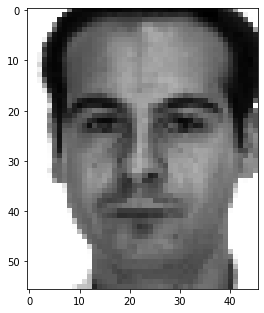

In [96]:
### 첫번째 데이터 출력해보기
img1 = matplotlib.image.imread(join('/content/drive/MyDrive/face-training-set/0001_0001.BMP'))
plt.figure()
plt.figure(figsize=(24,25))
plt.subplot(1,5,1, facecolor='w')
plt.imshow(img1, cmap='gray')



## 2. CNN 모델 정의


In [97]:
model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(W, H, 1)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(Nout, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 144, 144, 64)      640       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 70, 70, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 33, 33, 128)      

In [98]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

In [99]:
print('Train images :',train_X.shape)
print('Test images : ', test_X.shape)


Train images : (839, 144, 144, 1)
Test images :  (210, 144, 144, 1)


## 3. 모델 학습시키기 - train set 이용

In [100]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료
earlystop = EarlyStopping(patience=10)

# 학습률 조정
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,verbose=1,
                                            factor=0.5, min_lr=0.00001)

# callback 설정
callback = [earlystop, learning_rate_reduction]

In [101]:
#train_X = np.array(train_X)
#train_Y = np.array(train_Y)
#test_X = np.array(test_X)
#test_Y = np.array(test_Y)


In [102]:
#model.fit(train_X, train_Y, epochs=30)

In [103]:

history = model.fit(
  train_X, train_Y,
  epochs=epochs,
  batch_size=batch_size,
  validation_data=(test_X, test_Y),
  #shuffle=True,
  #callbacks=callback,
)

Epoch 1/100
9/9 [==============================] - 2s 139ms/step - loss: 5.9113 - accuracy: 0.0068 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.8635 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 1s 107ms/step - loss: 5.8588 - accuracy: 0.0038 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.8691 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 1s 111ms/step - loss: 5.8542 - accuracy: 0.0063 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.9024 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 1s 108ms/step - loss: 5.8450 - accuracy: 0.0042 - precision: 0.0000e+00 - re

## 4. 학습시킨 모델 검증 - test set 이용

In [113]:
loss, acc, precision, recall, f1score = model.evaluate(test_X, test_Y)

print("Loss: "+str(loss))
print("Accuracy: "+str(acc))
print("precision: "+str(precision))
print("recall: "+str(recall))
print("f1score: "+str(f1score))

7/7 [==============================] - 0s 16ms/step - loss: 3.9461 - accuracy: 0.6048 - precision: 0.6135 - recall: 0.5962 - f1score: 0.6046
Loss: 3.946103096008301
Accuracy: 0.6047618985176086
precision: 0.6134623289108276
recall: 0.596230149269104
f1score: 0.6046403050422668


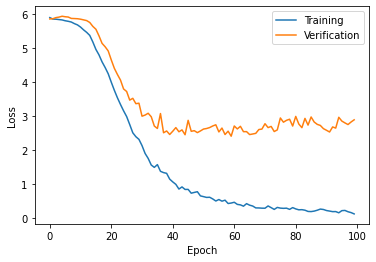

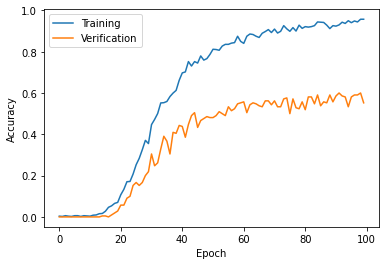

In [105]:

plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

## 5. 교차 검증


In [106]:
from sklearn.model_selection import StratifiedKFold, KFold

In [114]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(train_X, train_Y):

  # Define the model architecture
  model = model

  # Generate a print
  print('\n')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_X[train], train_Y[train],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(train_X[test], train_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('\n')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('\n')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('\n')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('\n')



Training for fold 1 ...
Score for fold 1: loss of 0.010981743223965168; accuracy of 100.0%


Training for fold 2 ...
Score for fold 2: loss of 0.013246842660009861; accuracy of 99.40476417541504%


Training for fold 3 ...
Score for fold 3: loss of 0.0027588538359850645; accuracy of 100.0%


Training for fold 4 ...
Score for fold 4: loss of 0.00025808156351558864; accuracy of 100.0%


Training for fold 5 ...
Score for fold 5: loss of 0.0005573948146775365; accuracy of 100.0%


Score per fold


> Fold 1 - Loss: 0.010981743223965168 - Accuracy: 100.0%


> Fold 2 - Loss: 0.013246842660009861 - Accuracy: 99.40476417541504%


> Fold 3 - Loss: 0.0027588538359850645 - Accuracy: 100.0%


> Fold 4 - Loss: 0.00025808156351558864 - Accuracy: 100.0%


> Fold 5 - Loss: 0.0005573948146775365 - Accuracy: 100.0%


Average scores for all folds:
> Accuracy: 99.88095283508301 (+- 0.23809432983398438)
> Loss: 0.0055605832196306436




In [124]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(test_X, test_Y):

  # Define the model architecture
  model = model

  scores = model.evaluate(test_X[test], test_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('\n')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('\n')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('\n')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('\n')


Score for fold 1: loss of 3.4843688011169434; accuracy of 59.52380895614624%
Score for fold 2: loss of 5.3879923820495605; accuracy of 64.28571343421936%
Score for fold 3: loss of 4.5406718254089355; accuracy of 54.76190447807312%
Score for fold 4: loss of 4.5075483322143555; accuracy of 54.76190447807312%
Score for fold 5: loss of 4.5002007484436035; accuracy of 66.66666865348816%


Score per fold


> Fold 1 - Loss: 3.4843688011169434 - Accuracy: 59.52380895614624%


> Fold 2 - Loss: 5.3879923820495605 - Accuracy: 64.28571343421936%


> Fold 3 - Loss: 4.5406718254089355 - Accuracy: 54.76190447807312%


> Fold 4 - Loss: 4.5075483322143555 - Accuracy: 54.76190447807312%


> Fold 5 - Loss: 4.5002007484436035 - Accuracy: 66.66666865348816%


Average scores for all folds:
> Accuracy: 60.0 (+- 4.856209589372298)
> Loss: 4.4841564178466795





## 6. 모델을 이용해 Test set을 예측 -> .csv 로 저장

In [120]:
import csv

test_dir = '/content/drive/MyDrive/face-test-set'
file_list = os.listdir(test_dir)

result = []


In [121]:
for file in file_list:
    name = file.split('.')[0]
    data = cv2.imread(test_dir+'/'+file, 0)
    data = cv2.resize(data, (W,H))
    data = np.asarray(data)
    data = data.reshape(-1,W,H,1)
    data = data / np.max(data)
    y = model.predict_classes(data)
    result.append([name, y])
#result=np.array(result)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [122]:

with open('./drive/MyDrive/1971063_김윤서_얼굴_2차_답안.csv', 'w', newline='') as f:
  write = csv.writer(f)
  write.writerow(['Image', 'Answer'])
  write.writerows(result)

In [123]:

#test_result_df = pd.DataFrame(data=result, index=["Image", "Answer"]).transpose()
 
#test_result_df = pd.DataFrame(result, columns=['Image', 'Answer'])
#test_result_df.head()

#test_result_df = test_result_df.sort_values(by="Image")
#test_result_df.head()

#test_result_df.to_csv("/content/drive/MyDrive/hw2-1-result.csv", index=False)